## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../data/'

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import cv2
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix


In [3]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPU
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 850M, pci bus id: 0000:0a:00.0, compute capability: 5.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 12.2 seconds.
Reverse indexing ...
Done reverse indexing in 4.0 seconds.


## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras Sequential</li>
<li> Changes to support single type input </li>
<li> VGGs take as input Lyft-style dataset </li>



In [5]:
import avod
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm. It uses two VGGs, one for images, one for LiDar, to find the bottleneck.
Img VGG and Bev VGG have the same strucure, just have input from different sources. 

<b>VGG:</b> VGG is a convolutional neural network model. Here simplified model wrt K. Simonyan and A. Zisserman's model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
Basically, it lacks dense layers at the end, and the last group of conv layers is smaller that theirs.
Two VGGs, one for BEV, one for Images

In [6]:
import utils.anchor_helper
from utils.frame_helper import FrameCalibrationData
import utils.frame_helper as frame_helper
import utils.preproc_helper as preproc_helper
import utils.bev_helper as bev_helper
import utils.rpn_helper as rpn_helper
import utils.rpn_keras as rpn_keras

In [7]:
from PIL import Image
from avod.core import anchor_filter
from avod.core import anchor_projector
from avod.core import box_3d_encoder
from avod.core import constants
from avod.core import losses
from avod.core import model
from avod.core import summary_utils
from avod.core.anchor_generators import grid_anchor_3d_generator
from avod.datasets.kitti import kitti_aug
import avod.datasets.kitti.kitti_utils as kitti_utils
from avod.core.label_cluster_utils import LabelClusterUtils

## Test this part!!

Tests and results for the RPN model part. The following changes to the model were done after errors/issues with testing:
<li>Maybe change the use of placeholders in the future, to fit with eager execution (shorter code)</li>
<li>Some internal keras os function rises a warning, something will be depreated, doesn't tell where and what function exactly</li>

In [8]:
import avod.builders.config_builder_util as config_build
config_path = 'avod/configs/unittest_model.config'
pipe_path = 'avod/configs/unittest_pipeline.config'
model_config = config_build.get_model_config_from_file(config_path)
pipeline_config=config_build.get_configs_from_pipeline_file(pipe_path, "val")
#rpn_model = RpnModel(model_config, pipeline_config[3],
 #                        train_val_test="val",
  #                     dataset=level5data)
# array=rpn_model.feed_input(5)
#predictions = rpn_model.build()
#tensor=tf.convert_to_tensor(array)


Get a scene, show the different methods to get the boxes. Loop to get all the samples

In [9]:
# Network input data: loop to get batch info
import io
from typing import Tuple, List

dataset=level5data

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

img_input_list=[]
img_target=[]
bev_input_list=[]
ground_plane_list=[]
lidar=[]
boxes_c=[]
boxes_b=[]
class_list=[]
cam_path_list=[]
bev_path_list=[]

my_scene = dataset.scene[0]

        
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
#arbitrary shape, must be square though!
bev_shape = (336,336, 3)
        
# Only handle one sample at a time for now
my_sample_token = my_scene["first_sample_token"]
my_last_sample_token = my_scene["last_sample_token"]
sample = dataset.get('sample', my_sample_token)
tok=sample['data']["CAM_FRONT"]
tok_bev=sample['data']["LIDAR_TOP"]
iboxes=dataset.get_boxes(tok)   
bboxes=dataset.get_boxes(tok_bev)
data_path, boxes, camera_intrinsic = dataset.get_sample_data(
                tok_bev)
data_path, uboxes, camera_intrinsic = dataset.get_sample_data(
                tok)

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))
print(iboxes[0], boxes[0].center/4)
#anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(tok, classes, dataset)
i=0
with tf.device('/GPU:0'):
    while my_sample_token!=my_last_sample_token:
        
        clss=[]
        
        sample = dataset.get('sample', my_sample_token)
        sample_name = sample.get("token")
        img_data = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_data.get("token")

        tok=sample['data']["CAM_FRONT"]
        ego_pose = dataset.get("ego_pose", img_data["ego_pose_token"])
        cam_path, boxes_cam, camera_intrinsic = dataset.get_sample_data(camera_token)
        cam_path_list.append(cam_path)
        data = Image.open(cam_path)
        boxes_c.append(np.asarray(boxes_cam))
        for t in boxes_cam:
            clss.append(t.name)
        class_list.append(clss)
        #anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, classes, dataset)
        #print(label_boxes_3d.shape)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        bev_data = bev_input
        bev_token= bev_input.get("token")
        lidar_data = dataset.get("sample_data", bev_token)
        lidar_filepath = dataset.get_sample_data_path(bev_token)
        bev_path_list.append(lidar_filepath)
        ego_pose = dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        lidar.append(lidar_pointcloud.points)
        x=sample["data"]["LIDAR_TOP"]
        bevboxes=dataset.get_boxes(x)
        boxes_b.append(bevboxes)
        bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        #ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_array = bev_helper.normalize_voxel_intensities(bev)
        bev_input_list.append(bev_array)

        file_name=dataset.get_sample_data_path(camera_token)
        image1 = Image.open(file_name)
        # compress image, it is too big
        # convert image to numpy array
        image = image1.resize((358,300), Image.ANTIALIAS)
        img_array = np.asarray(image)
        img_input_list.append(img_array)

        cam_front_token = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        cam_front_data = cam_front_token.get("calibrated_sensor_token")
        cam_front_calib = dataset.get("calibrated_sensor", cam_front_data )
        cam_front_coords = cam_front_calib.get("translation")

        cam_front_left_token = dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
        cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
        cam_front_left_calib = dataset.get("calibrated_sensor", cam_front_left_data )
        cam_front_left_coords = cam_front_left_calib.get("translation")

        cam_front_right_token = dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
        cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
        cam_front_right_calib = dataset.get("calibrated_sensor", cam_front_right_data )
        cam_front_right_coords = cam_front_right_calib.get("translation")

        ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)
        ground_plane_list.append(ground_plane)
        
        token=img_data.get("calibrated_sensor_token") 
        stereo_calib_p2 = frame_helper.read_calibration(token, dataset)

        my_sample_token = dataset.get("sample", my_sample_token)["next"]
        i=i+1


label: nan, score: nan, xyz: [2770.57, 617.90, -18.93], wlh: [1.80, 4.41, 1.55], rot axis: [0.00, 0.00, 1.00], ang(degrees): 27.81, ang(rad): 0.49, vel: nan, nan, nan, name: car, token: 4afda06e07e481c20f6dbf697370f73b89cf51a4ada194bc8ca332c62a9f4f44 [ 6.37802323  2.65938224 -0.10038785]


In [10]:
from lyft_dataset_sdk.utils.geometry_utils import view_points
import matplotlib.patches as patches

In [11]:
img_input=np.asarray(img_input_list)
bev_input=np.asarray(bev_input_list)
#img_targetnp=np.asarray(img_target)
img_input=tf.convert_to_tensor(img_input)
print(img_input.shape)

(125, 300, 358, 3)


create anchors, recalibrate camera matrix and gt boxes to fit the reshaping of the img

In [12]:
x=[camera_intrinsic[0], camera_intrinsic[1], camera_intrinsic[2]]
x=np.asarray(x)
gt_boxes_corners=[]
gt_boxes_corners_2=[]
print(len(boxes_c))
for i in range(len(boxes_c)):    
    corner_img_list=[]
    corn2=[]
    for j in range(len(boxes_c[i])):
        corners = view_points(boxes_c[i][j].corners(), view=x, normalize=True)[:2, :]
        np_corners=corners.T[:4]
        corners_norm=[min(np_corners[0][0], np_corners[1][0]), min(np_corners[1][1],np_corners[2][1]), max(np_corners[0][0], np_corners[1][0]), max(np_corners[2][1],np_corners[1][1])]
        corn_2=[min(corners[0]), min(corners[1]), max(corners[0], ), max(corners[1])]
        corner_img_list.append(corners_norm)
        corn2.append(corn_2)
    gt_boxes_corners.append(np.asarray(corner_img_list))
    gt_boxes_corners_2.append(corn2)
print(np.asarray(gt_boxes_corners).shape, len(gt_boxes_corners_2)) #125, num box in scene, 4

125
(125,) 125


[[786.86374568 798.57954166 798.73736105 787.01231924 788.5693966
  800.60407211 800.76775821 788.72332661]
 [537.93350571 537.9100299  566.04833393 566.03073169 537.68144847
  537.65696049 566.55538268 566.536545  ]]


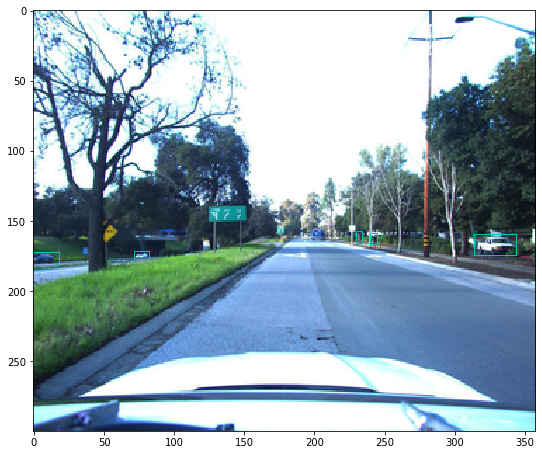

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(image)
corners = view_points(boxes_c[124][0].corners(), x, normalize=True)[:2, :]
corners1 = view_points(boxes_c[124][1].corners(), x, normalize=True)[:2, :]
print(corners)
# Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
np_corners=corners.T[:4]
np_corners1=corners1.T[:4]
boxes_c[124][0]
# boxes_c[124][0].render(ax, view=x, normalize=True)
# boxes_c[124][1].render(ax, view=x, normalize=True)
# boxes_c[124][2].render(ax, view=x, normalize=True)
# boxes_c[124][3].render(ax, view=x, normalize=True)
# boxes_c[124][4].render(ax, view=x, normalize=True)

rect1 = patches.Rectangle((np_corners1[1][0], np_corners1[1][1]), np_corners1[0][0]-np_corners1[1][0], -np_corners1[1][1]+np_corners1[2][1],linewidth=1,edgecolor="r")
rect2 = patches.Rectangle((np_corners[1][0], np_corners[1][1]), np_corners[0][0]-np_corners[1][0], -np_corners[1][1]+np_corners[2][1],linewidth=1,edgecolor="r")
# Add the patch to the Axes
# ax.add_patch(rect2)
# ax.add_patch(rect1)
for i in gt_boxes_corners_2[124]:
    rect= patches.Rectangle([i[0]*0.292,i[1]*0.292],   i[2]*0.292-i[0]*0.292, i[3]*0.292-i[1]*0.292,linewidth=1,edgecolor="c", fill=False)
    ax.add_patch(rect)


In [ ]:
print(class_list[124][0],gt_boxes_corners[124][0][1])
with open("annotation.txt", "w+") as f:
    for i in range(len(cam_path_list)):
        #boxes_c and class_list have the same structure so its ok
        for j in range(len(class_list[i])):
            f.write(str(cam_path_list[i]) + ',' + str(gt_boxes_corners_2[i][j][0]) + ',' + str(gt_boxes_corners_2[i][j][1]) + ',' + str(gt_boxes_corners_2[i][j][2]) + ',' + str(gt_boxes_corners_2[i][j][3]) + ',' + class_list[i][j] + '\n')

Same done above for bev

In [ ]:
# from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility
# fig, ax2 = plt.subplots(1, 1, figsize=(9, 16))
# bev1 = bev_helper.normalize_voxel_intensities(bev)
# bev = bev_helper.normalize_voxel_intensities(bev)
# bev2=bev
# ax2.imshow(bev1)
# sample_lidar_token = sample["data"]["LIDAR_TOP"]
# print(sample_lidar_token)
# _, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
# ego_p=dataset.get("ego_pose", lidar_data["ego_pose_token"])
# bev_helper.move_boxes_to_car_space(bevboxes, ego_pose)
# bev_helper.scale_boxes(bevboxes, 0.8)
# corners=bev_helper.draw_boxes(bev, voxel_size, boxes, classes, z_offset=z_offset)
# fig, ax3 = plt.subplots(1, 1, figsize=(9, 16))
# ax3.imshow(bev)

In [ ]:
# corners_voxel_list=[]
# for box in boxes:   
#     corners = box.bottom_corners()
#     corners_voxel = bev_helper.car_to_voxel_coords(corners, [336,336,3], voxel_size, z_offset).transpose(1,0)
#     corners_voxel = corners_voxel[:,:2] # Drop z coord
#     corners_voxel_list.append(corners_voxel)
#     cv2.drawContours(bev, np.int0([corners_voxel]), 0, -1)
# plt.imshow(bev)
# print(corners_voxel_list)

In [ ]:
# from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points
# def visualize_lidar_of_sample(sample_token, axes_limit=80):
#     sample = level5data.get("sample", sample_token)
#     sample_lidar_token = sample["data"]["LIDAR_TOP"]
#     level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
# #visualize_lidar_of_sample(sample_name)
# my_last_sample_token = my_scene["last_sample_token"]
# sample = level5data.get("sample", my_last_sample_token)
# #sample = level5data.get("sample", sample_name)
# sample_lidar_token = sample["data"]["LIDAR_TOP"]
# print(sample_lidar_token)
# _, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
# print(len(boxes))
# sd_record = dataset.get("sample_data", sample_lidar_token)
# # Get aggregated point cloud in lidar frame.
# sample_rec = dataset.get("sample", sd_record["sample_token"])
# chan = sd_record["channel"]
# ref_chan = "LIDAR_TOP"
# pc, times = LidarPointCloud.from_file_multisweep(
#     dataset, sample_rec, chan, ref_chan, num_sweeps=1
# )

# # Compute transformation matrices for lidar point cloud
# cs_record = dataset.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
# pose_record = dataset.get("ego_pose", sd_record["ego_pose_token"])
# vehicle_from_sensor = np.eye(4)
# vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
# vehicle_from_sensor[:3, 3] = cs_record["translation"]

# ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
# rot_vehicle_flat_from_vehicle = np.dot(
#     Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
#     Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
# )

# vehicle_flat_from_vehicle = np.eye(4)
# vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle

# # Init axes.
# _, ax = plt.subplots(1, 1, figsize=(9, 9))


# # Show point cloud.
# points = view_points(
#     pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
# )

# dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
# colors = np.minimum(1, dists / 40 / np.sqrt(2))
# ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# # Show ego vehicle.
# ax.plot(0, 0, "x", color="red")

# # Show boxes.
# for box in boxes:
#     box.render(ax, view=np.eye(4), colors=("c", "c", "c"))

# # Limit visible range.
# ax.set_xlim(-70, 70)
# ax.set_ylim(-70, 70)
# ax.axis("off")
# ax.set_title(sd_record["channel"])
# ax.set_aspect("equal")

compute rpn

In [14]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import regularizers, initializers

from utils import rpn_keras

In [15]:
from utils.rpn_keras import Config

base_path = 'G:/lyft/nuscenes-devkit/avod_lyft'
train_path =  'G:/lyft/nuscenes-devkit/avod_lyft/annotation.txt' # Training data (annotation file)

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_vgg.hdf5')
record_path = os.path.join(base_path, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)
base_weight_path = os.path.join(base_path, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

# Create the config
C = Config()
C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90
C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois
C.base_net_weights = base_weight_path

In [16]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = rpn_keras.get_data(train_path)
print(train_imgs[10])
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=897{'filepath': 'G:\\lyft\\nuscenes-devkit\\avod_lyft\\..\\data\\images\\host-a004_cam0_1233011745251064006.jpeg', 'width': 1224, 'height': 1024, 'bboxes': [{'class': 'car', 'x1': 769.048072102866, 'x2': 831.5329604908799, 'y1': 523.748932288949, 'y2': 547.7366358897605}, {'class': 'car', 'x1': 611.8439817908943, 'x2': 643.0686603367569, 'y1': 534.3718580165165, 'y2': 564.9804697970678}, {'class': 'car', 'x1': 864.3473003549273, 'x2': 929.4146983793793, 'y1': 512.4670215528483, 'y2': 541.111101375577}, {'class': 'car', 'x1': 841.9185802107122, 'x2': 913.0438331107041, 'y1': 517.0874165227879, 'y2': 540.7284679351031}, {'class': 'car', 'x1': 948.2512989729534, 'x2': 1015.1697121486752, 'y1': 505.3603805245588, 'y2': 533.1671029318077}, {'class': 'car', 'x1': 547.8100235754619, 'x2': 586.202011311581, 'y1': 530.7681427996233, 'y2': 561.819448951677}, {'class': 'car', 'x1': 460.7148802806852, 'x2': 550.016305652836, 'y1': 538.2388878118601, 'y2': 597.900761106

In [17]:
classes_count['bg'] = 0
class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
print(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C,config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Training images per class:
{'car': 800, 'pedestrian': 54, 'bus': 25, 'other_vehicle': 9, 'bicycle': 9, 'bg': 0}
Num classes (including bg) = 6
{'car': 0, 'pedestrian': 1, 'bus': 2, 'other_vehicle': 3, 'bicycle': 4, 'bg': 5}
Config has been written to G:/lyft/nuscenes-devkit/avod_lyft\model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [18]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 125


In [19]:
data_gen_train = rpn_keras.get_anchor_gt(train_imgs, C, rpn_keras.get_img_output_length, mode='train')

In [30]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

10


### SHOW ANCHORS 

Original image: height=1224 width=1024
Resized image:  height=358 width=300 C.im_size=300
Feature map size: height=22 width=18 C.rpn_stride=16
(1, 358, 300, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 22, 18, 18)
Shape of y_rpn_regr (1, 22, 18, 72)
{'filepath': 'G:\\lyft\\nuscenes-devkit\\avod_lyft\\..\\data\\images\\host-a004_cam0_1233011750451064006.jpeg', 'width': 1024, 'height': 1224, 'bboxes': [{'class': 'car', 'x1': 454.81378471811286, 'x2': 473.475235917236, 'y1': 626.2401987029193, 'y2': 648.4281496703678}, {'class': 'car', 'x1': 387.27611505990785, 'x2': 476.0379096876468, 'y1': 699.1046894870198, 'y2': 816.2896890393595}, {'class': 'car', 'x1': 393.6080840420158, 'x2': 448.60662520404924, 'y1': 1079.9302424265568, 'y2': 1229.8107943401542}, {'class': 'pedestrian', 'x1': 413.1820886102971, 'x2': 493.4008549525274, 'y1': 320.4453222225476, 'y2': 362.66858750055394}, {'class': 'bus', 'x1': 430.63000584467125, 'x2': 476.42787791990406, 'y1': 865.352717409519

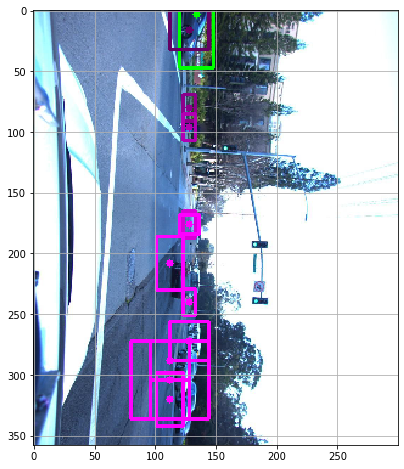

In [31]:
from matplotlib import transforms
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))
    
    gt_x1, gt_x2 = image_data['bboxes'][7]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][7]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][7]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][7]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    print("gt",gt_x1, gt_y1, gt_x2, gt_y2)
    
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    #cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    #cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    #cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#        cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

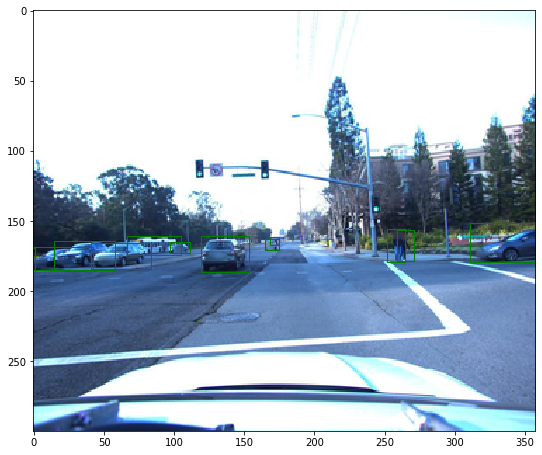

In [32]:
path=train_imgs[9].get("filepath")
bbox=train_imgs[9].get("bboxes")
img10=Image.open(path)
img10 = img10.resize((358,300), Image.ANTIALIAS)
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(img10)
coords=[]
for i in bbox:
    x1=i.get("x1")
    y1=i.get("y1")
    x2=i.get("x2")
    y2=i.get("y2")
    coords.append([x1,y1,x2,y2])
s=img10.size
for t in coords:
    rect= patches.Rectangle([t[0]*s[0]/1224 ,t[1]*s[1]/1024],   (t[2]-t[0])*s[0]/1224, (t[3]-t[1])*s[1]/1024,linewidth=1,edgecolor="g", fill=False)
    ax.add_patch(rect)

In [33]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
with tf.device('/CPU:0'):
    shared_layers = rpn_keras.nn_base(img_input, trainable=True)

In [50]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
with tf.device('/CPU:0'):
    rpn = rpn_keras.rpn_layer(shared_layers, num_anchors)
    classifier = rpn_keras.classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

    model_rpn = Model(img_input, rpn[:2])
    model_classifier = Model([img_input, roi_input], classifier)

    # this is a model that holds both the RPN and the classifier, used to load/save weights for the models
    model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
              https://github.com/fchollet/deep-learning-models/releases/tag/v0.1')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

Continue training based on previous trained model
Loading weights from G:/lyft/nuscenes-devkit/avod_lyft\model/model_frcnn_vgg.hdf5
Already train 4K batches


In [35]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
with tf.device('/CPU:0'):
    model_rpn.compile(optimizer=optimizer, loss=[rpn_keras.rpn_loss_cls(num_anchors), rpn_keras.rpn_loss_regr(num_anchors)])
    model_classifier.compile(optimizer=optimizer_classifier, loss=[rpn_keras.class_loss_cls, rpn_keras.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
    model_all.compile(optimizer='sgd', loss='mae')

In [36]:
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 1000
num_epochs = 40
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [42]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4
with tf.device('/CPU:0'):
    start_time = time.time()
    for epoch_num in range(num_epochs):

        progbar = generic_utils.Progbar(epoch_length)
        print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))

        r_epochs += 1

        while True:
            try:

                if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                    mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                    rpn_accuracy_rpn_monitor = []
                    print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                    if mean_overlapping_bboxes == 0:
                        print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

                # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
                X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)
                # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
                loss_rpn = model_rpn.train_on_batch(X, Y)
                # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
                P_rpn = model_rpn.predict_on_batch(X)
                # R: bboxes (shape=(300,4))
                # Convert rpn layer to roi bboxes
                R = rpn_keras.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
                # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
                # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
                # Y1: one hot code for bboxes from above => x_roi (X)
                # Y2: corresponding labels and corresponding gt bboxes
                X2, Y1, Y2, IouS = rpn_keras.calc_iou(R, img_data, C, class_mapping)
                # If X2 is None means there are no matching bboxes
                if X2 is None:
                    rpn_accuracy_rpn_monitor.append(0)
                    rpn_accuracy_for_epoch.append(0)
                    continue

                # Find out the positive anchors and negative anchors
                neg_samples = np.where(Y1[0, :, -1] == 1)
                pos_samples = np.where(Y1[0, :, -1] == 0)
                if len(neg_samples) > 0:
                    neg_samples = neg_samples[0]
                else:
                    neg_samples = []

                if len(pos_samples) > 0:
                    pos_samples = pos_samples[0]
                else:
                    pos_samples = []

                rpn_accuracy_rpn_monitor.append(len(pos_samples))
                rpn_accuracy_for_epoch.append((len(pos_samples)))

                if C.num_rois > 1:
                    # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                    if len(pos_samples) < C.num_rois//2:
                        selected_pos_samples = pos_samples.tolist()
                    else:
                        selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                    # Randomly choose (num_rois - num_pos) neg samples
                    try:
                        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                    except:
                        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                    # Save all the pos and neg samples in sel_samples
                    sel_samples = selected_pos_samples + selected_neg_samples
                else:
                    # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                    selected_pos_samples = pos_samples.tolist()
                    selected_neg_samples = neg_samples.tolist()
                    if np.random.randint(0, 2):
                        sel_samples = random.choice(neg_samples)
                    else:
                        sel_samples = random.choice(pos_samples)
                # training_data: [X, X2[:, sel_samples, :]]
                # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
                #  X                     => img_data resized image
                #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
                #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
                #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
                loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
                losses[iter_num, 0] = loss_rpn[1]
                losses[iter_num, 1] = loss_rpn[2]

                losses[iter_num, 2] = loss_class[1]
                losses[iter_num, 3] = loss_class[2]
                losses[iter_num, 4] = loss_class[3]

                iter_num += 1

                progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                          ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
                
                if iter_num == epoch_length:
                    loss_rpn_cls = np.mean(losses[:, 0])
                    loss_rpn_regr = np.mean(losses[:, 1])
                    loss_class_cls = np.mean(losses[:, 2])
                    loss_class_regr = np.mean(losses[:, 3])
                    class_acc = np.mean(losses[:, 4])
                    print("error here")
                    mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                    rpn_accuracy_for_epoch = []

                    if C.verbose:
                        print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                        print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                        print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                        print('Loss RPN regression: {}'.format(loss_rpn_regr))
                        print('Loss Detector classifier: {}'.format(loss_class_cls))
                        print('Loss Detector regression: {}'.format(loss_class_regr))
                        print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                        print('Elapsed time: {}'.format(time.time() - start_time))
                        elapsed_time = (time.time()-start_time)/60

                    curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                    iter_num = 0
                    start_time = time.time()

                    if curr_loss < best_loss:
                        print("here the error")
                        if C.verbose:
                            print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                        best_loss = curr_loss
                        model_all.save_weights(C.model_path)

                    new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                               'class_acc':round(class_acc, 3), 
                               'loss_rpn_cls':round(loss_rpn_cls, 3), 
                               'loss_rpn_regr':round(loss_rpn_regr, 3), 
                               'loss_class_cls':round(loss_class_cls, 3), 
                               'loss_class_regr':round(loss_class_regr, 3), 
                               'curr_loss':round(curr_loss, 3), 
                               'elapsed_time':round(elapsed_time, 3), 
                               'mAP': 0}

                    record_df = record_df.append(new_row, ignore_index=True)
                    record_df.to_csv(record_path, index=0)

                    break

            except Exception as e:
                print('Exception: {}'.format(e))
                continue

    print('Training complete, exiting.')

Epoch 6/40
56
Exception: in user code:

    C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    G:\lyft\nuscenes-devkit\avod_lyft\utils\rpn_keras.py:813 class_loss_regr_fixed_num  *
        x = y_true[:, :, 4*num_classes:] - y_pred
    C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1141 binary_op_wrapper
        raise e
    C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    C:\Users\Utente1\AppData\Ro

KeyboardInterrupt: 

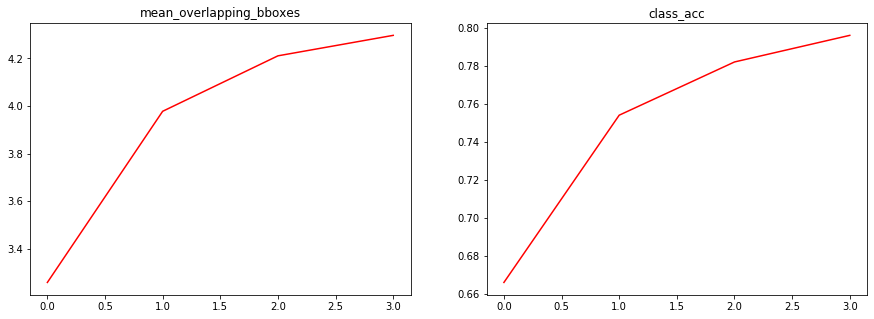

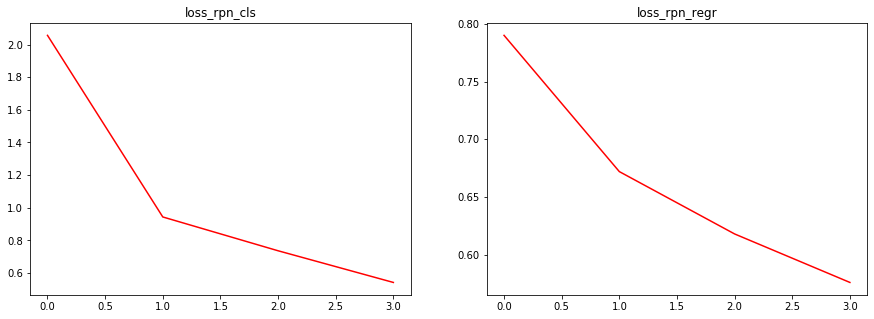

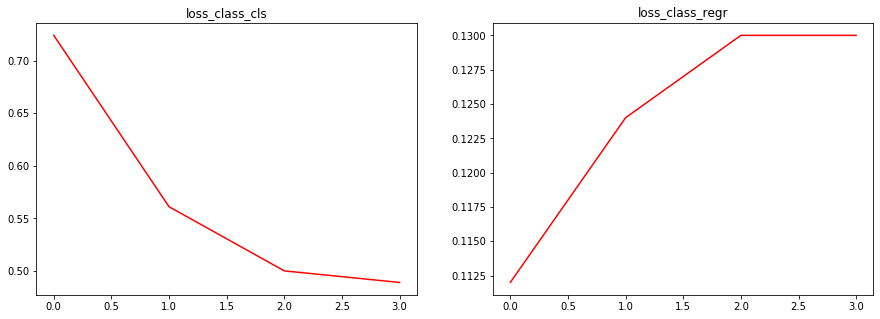

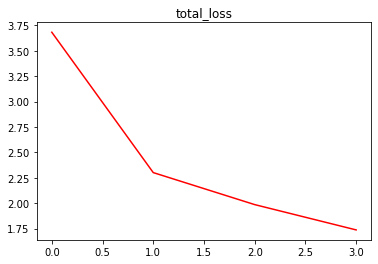

In [49]:
r_epochs=4
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()